In [8]:
# Code liberally inspired by and pulled from:
# https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

In [20]:
import numpy as np

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.activations import relu
from keras.models import load_model
import random
from keras.applications.vgg16 import preprocess_input

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# Load Data
X_dev = np.load('X_dev_224.npy')
print(X_dev.shape)

(2426, 224, 224, 3)


In [7]:
# Load Model
model = load_model('bestVGG16.h5')

In [9]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

(224, 224, 3)


Text(0.5, 1.0, 'ORIGINAL IMAGE')

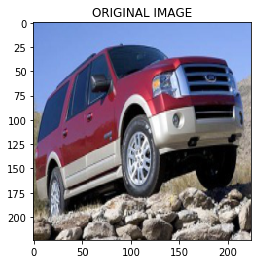

In [65]:
# Choose a random image from the dev set
rand_ind = random.randint(1, len(X_dev))
rand_image = X_dev[rand_ind]
print(rand_image.shape)
plt.imshow(rand_image)
plt.title('ORIGINAL IMAGE')

In [ ]:
image = rand_image.reshape((1, rand_image.shape[0], rand_image.shape[1], rand_image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
yhat = model.predict(image)
temp = image[0]
print(temp.shape)
heatmap = np.zeros((224,224))
correct_class = np.argmax(yhat)
for n,(x,y,image) in enumerate(iter_occlusion(temp,14)):
    heatmap[x:x+14,y:y+14] = model.predict(image.reshape((1, image.shape[0], image.shape[1], image.shape[2])))[0][correct_class]
heatmap1 = heatmap/heatmap.max()
plt.imshow(heatmap)

(224, 224, 3)
padding...


In [ ]:
import skimage.io as io
#creating mask from the standardised heatmap probabilities
mask = heatmap1 < 0.85
mask1 = mask *256
mask = mask.astype(int)
io.imshow(mask,cmap='gray')

In [ ]:
import cv2
#read the image
image = cv2.cvtColor(rand_image,cv2.COLOR_BGR2RGB)
#resize image to appropriate dimensions
image = cv2.resize(image,(224,224))
mask = mask.astype('uint8')
#apply the mask to the image
final = cv2.bitwise_and(image,image,mask = mask)
final = cv2.cvtColor(final,cv2.COLOR_BGR2RGB)
#plot the final image
plt.imshow(final)

In [ ]:
plt.imsave('occlusion_map/img9.png', final)